Analyzing function f1...
Analyzing function f2...


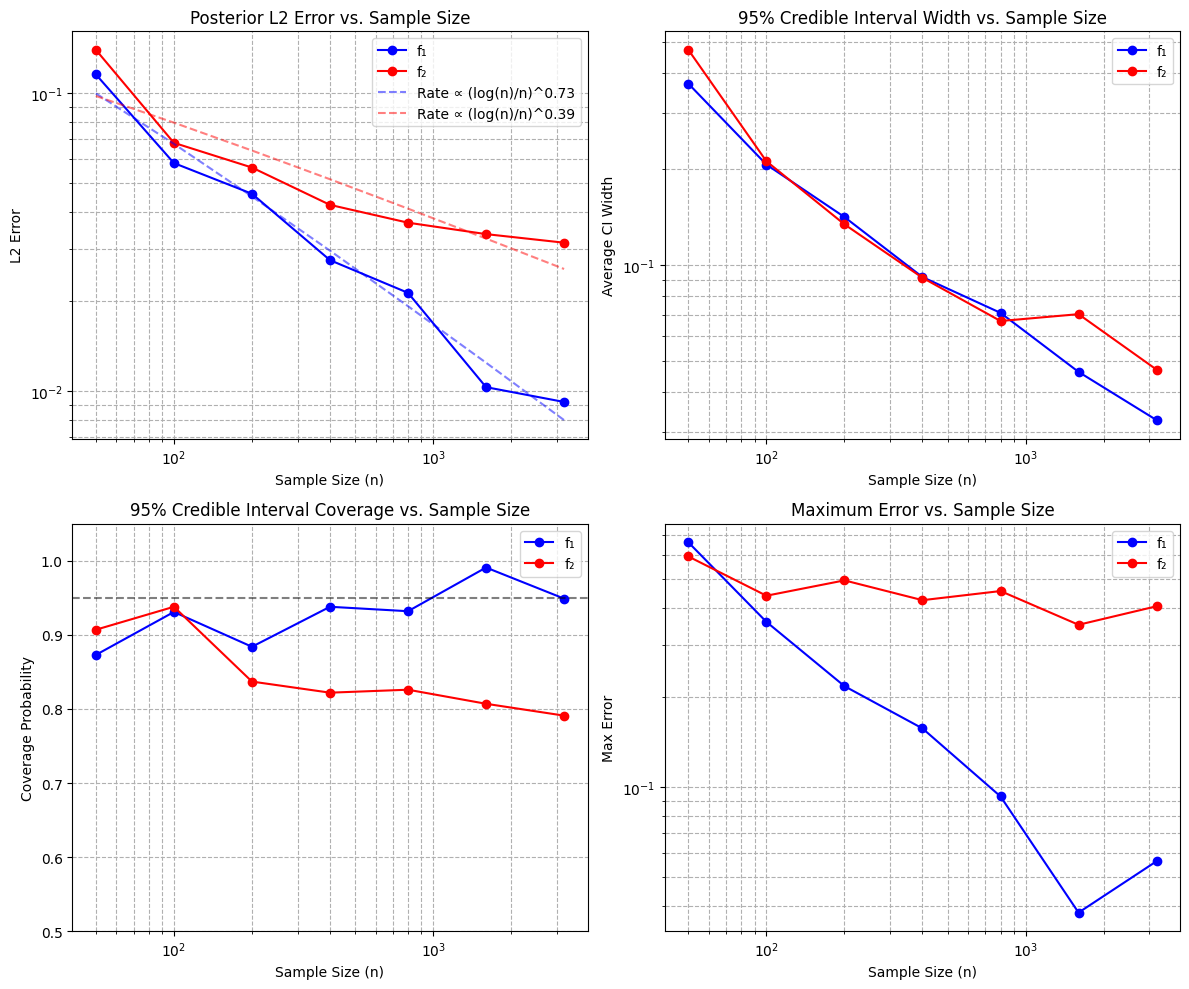

Estimated contraction rate for smooth function f1: (log(n)/n)^0.734
Estimated contraction rate for less smooth function f2: (log(n)/n)^0.389


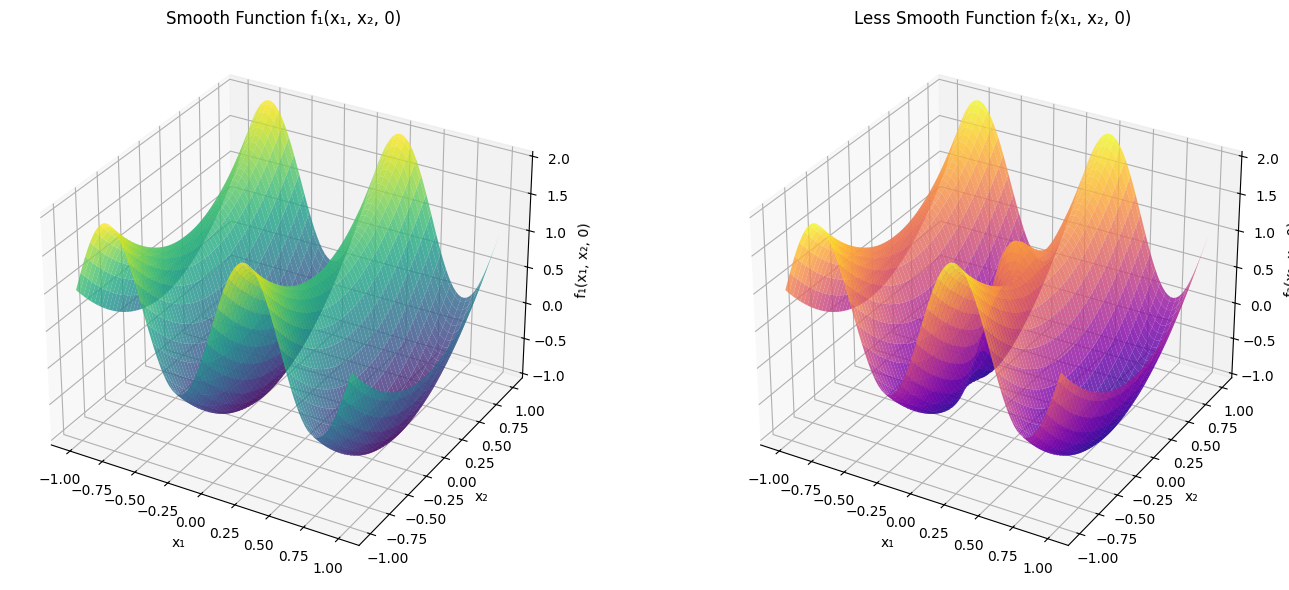

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import scipy.stats as stats

# Set random seed for reproducibility
np.random.seed(42)

# Define true functions
def f1(X):
    """Smooth function: sin(2π*x₁) + x₂² + 0.5x₃"""
    return np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2 + 0.5 * X[:, 2]

def f2(X):
    """Less smooth function with local feature"""
    base = np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2 + 0.5 * X[:, 2]
    bump = np.exp(-30 * np.sum(X**2, axis=1))
    return base + bump

# Function to generate data
def generate_data(func, n_samples, noise_level=0.1):
    """Generate n_samples with random inputs and noisy outputs"""
    X = np.random.uniform(-1, 1, (n_samples, 3))
    y_true = func(X)
    y = y_true + np.random.normal(0, noise_level, n_samples)
    return X, y, y_true

# Function to compute posterior contraction metrics
def compute_contraction_metrics(model, func, X_test, sample_sizes, noise_level=0.1):
    """
    Compute posterior contraction metrics for different sample sizes
    Returns L2 error, KL divergence, and credible interval coverage
    """
    l2_errors = []
    credible_widths = []
    coverages = []
    max_errors = []
    
    y_test_true = func(X_test)
    
    for n in sample_sizes:
        # Generate training data
        X_train, y_train, _ = generate_data(func, n, noise_level)
        
        # Fit GP model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred, y_std = model.predict(X_test, return_std=True)
        
        # Compute L2 error
        l2_error = np.sqrt(np.mean((y_pred - y_test_true)**2))
        l2_errors.append(l2_error)
        
        # Compute max error
        max_error = np.max(np.abs(y_pred - y_test_true))
        max_errors.append(max_error)
        
        # Compute average width of 95% credible interval
        credible_width = 2 * 1.96 * np.mean(y_std)
        credible_widths.append(credible_width)
        
        # Compute credible interval coverage
        lower = y_pred - 1.96 * y_std
        upper = y_pred + 1.96 * y_std
        coverage = np.mean((lower <= y_test_true) & (y_test_true <= upper))
        coverages.append(coverage)
    
    return l2_errors, credible_widths, coverages, max_errors

# Function to fit theoretical curve
def fit_contraction_rate(sample_sizes, errors):
    """Fit a curve of form C*(log(n)/n)^β to the errors"""
    log_errors = np.log(errors)
    log_terms = np.log(np.log(sample_sizes) / sample_sizes)
    
    # Linear regression to find β
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_terms, log_errors)
    beta = slope
    C = np.exp(intercept)
    
    return C, beta

# Function to create plots
def plot_contraction_results(sample_sizes, metrics1, metrics2, function_names=["f₁", "f₂"]):
    """Plot the contraction results for both functions"""
    l2_errors1, widths1, coverages1, max_errors1 = metrics1
    l2_errors2, widths2, coverages2, max_errors2 = metrics2
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot L2 errors
    axes[0, 0].loglog(sample_sizes, l2_errors1, 'bo-', label=function_names[0])
    axes[0, 0].loglog(sample_sizes, l2_errors2, 'ro-', label=function_names[1])
    
    # Fit theoretical contraction rates
    C1, beta1 = fit_contraction_rate(sample_sizes, l2_errors1)
    C2, beta2 = fit_contraction_rate(sample_sizes, l2_errors2)
    
    theoretical_curve1 = C1 * (np.log(sample_sizes) / sample_sizes) ** beta1
    theoretical_curve2 = C2 * (np.log(sample_sizes) / sample_sizes) ** beta2
    
    axes[0, 0].loglog(sample_sizes, theoretical_curve1, 'b--', alpha=0.5, 
                     label=f'Rate ∝ (log(n)/n)^{beta1:.2f}')
    axes[0, 0].loglog(sample_sizes, theoretical_curve2, 'r--', alpha=0.5, 
                     label=f'Rate ∝ (log(n)/n)^{beta2:.2f}')
    
    axes[0, 0].set_title('Posterior L2 Error vs. Sample Size')
    axes[0, 0].set_xlabel('Sample Size (n)')
    axes[0, 0].set_ylabel('L2 Error')
    axes[0, 0].legend()
    axes[0, 0].grid(True, which="both", ls="--")
    
    # Plot credible interval widths
    axes[0, 1].loglog(sample_sizes, widths1, 'bo-', label=function_names[0])
    axes[0, 1].loglog(sample_sizes, widths2, 'ro-', label=function_names[1])
    axes[0, 1].set_title('95% Credible Interval Width vs. Sample Size')
    axes[0, 1].set_xlabel('Sample Size (n)')
    axes[0, 1].set_ylabel('Average CI Width')
    axes[0, 1].legend()
    axes[0, 1].grid(True, which="both", ls="--")
    
    # Plot coverage probabilities
    axes[1, 0].semilogx(sample_sizes, coverages1, 'bo-', label=function_names[0])
    axes[1, 0].semilogx(sample_sizes, coverages2, 'ro-', label=function_names[1])
    axes[1, 0].axhline(0.95, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('95% Credible Interval Coverage vs. Sample Size')
    axes[1, 0].set_xlabel('Sample Size (n)')
    axes[1, 0].set_ylabel('Coverage Probability')
    axes[1, 0].set_ylim(0.5, 1.05)
    axes[1, 0].legend()
    axes[1, 0].grid(True, which="both", ls="--")
    
    # Plot max errors
    axes[1, 1].loglog(sample_sizes, max_errors1, 'bo-', label=function_names[0])
    axes[1, 1].loglog(sample_sizes, max_errors2, 'ro-', label=function_names[1])
    axes[1, 1].set_title('Maximum Error vs. Sample Size')
    axes[1, 1].set_xlabel('Sample Size (n)')
    axes[1, 1].set_ylabel('Max Error')
    axes[1, 1].legend()
    axes[1, 1].grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.show()
    
    return beta1, beta2

# Main execution function
def analyze_contraction_rates():
    # Define sample sizes to test
    sample_sizes = np.array([50, 100, 200, 400, 800, 1600, 3200])
    
    # Generate test data for evaluation
    n_test = 1000
    X_test = np.random.uniform(-1, 1, (n_test, 3))
    
    # Define kernels with different length scales for each dimension
    length_scales = [0.5, 0.3, 0.7]
    kernel = ConstantKernel(1.0) * RBF(length_scale=length_scales)
    
    # Create GP model
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.01,  # Noise level
        normalize_y=True,
        n_restarts_optimizer=5
    )
    
    # Compute contraction metrics for both functions
    print("Analyzing function f1...")
    metrics1 = compute_contraction_metrics(gpr, f1, X_test, sample_sizes)
    
    print("Analyzing function f2...")
    metrics2 = compute_contraction_metrics(gpr, f2, X_test, sample_sizes)
    
    # Plot results
    beta1, beta2 = plot_contraction_results(sample_sizes, metrics1, metrics2)
    
    print(f"Estimated contraction rate for smooth function f1: (log(n)/n)^{beta1:.3f}")
    print(f"Estimated contraction rate for less smooth function f2: (log(n)/n)^{beta2:.3f}")
    
    # Visualize the functions in 2D slices
    visualize_functions(f1, f2)

# Function to visualize the true functions in 2D slices
def visualize_functions(f1, f2):
    fig = plt.figure(figsize=(15, 6))
    
    # Create meshgrid for x1, x2 with x3=0
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X_slice = np.column_stack((X1.ravel(), X2.ravel(), np.zeros(X1.size)))
    
    # Evaluate functions on the grid
    Z1 = f1(X_slice).reshape(X1.shape)
    Z2 = f2(X_slice).reshape(X1.shape)
    
    # Plot f1
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X1, X2, Z1, cmap=cm.viridis, alpha=0.8)
    ax1.set_title('Smooth Function f₁(x₁, x₂, 0)')
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.set_zlabel('f₁(x₁, x₂, 0)')
    
    # Plot f2
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X1, X2, Z2, cmap=cm.plasma, alpha=0.8)
    ax2.set_title('Less Smooth Function f₂(x₁, x₂, 0)')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('x₂')
    ax2.set_zlabel('f₂(x₁, x₂, 0)')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    analyze_contraction_rates()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from functools import partial

# Set random seed for reproducibility
np.random.seed(42)

# Define true functions - additive structure
def f1(X):
    """Smooth additive function: component for each dimension"""
    return np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2 + 0.5 * X[:, 2]

def f2(X):
    """Less smooth function with interaction terms"""
    base = np.sin(2 * np.pi * X[:, 0]) + X[:, 1]**2 + 0.5 * X[:, 2]
    interaction = 2 * X[:, 0] * X[:, 1] * X[:, 2]  # 3-way interaction
    bump = np.exp(-30 * np.sum(X**2, axis=1))
    return base + interaction + bump

# # Custom additive kernel implementation
# class AdditiveKernel:
#     def __init__(self, kernels, active_dims=None):
#         self.kernels = kernels
#         if active_dims is None:
#             self.active_dims = [list(range(i, i+1)) for i in range(len(kernels))]
#         else:
#             self.active_dims = active_dims
    
#     def __call__(self, X, Y=None):
#         if Y is None:
#             Y = X
#         K = np.zeros((X.shape[0], Y.shape[0]))
#         for kernel, dims in zip(self.kernels, self.active_dims):
#             K += kernel(X[:, dims], Y[:, dims])
#         return K
    
#     def get_params(self, deep=True):
#         return {"kernels": self.kernels, "active_dims": self.active_dims}

# Orthogonal Additive Kernel implementation
class OAK:
    def __init__(self, base_kernels, active_dims=None):
        self.base_kernels = base_kernels
        if active_dims is None:
            self.active_dims = [list(range(i, i+1)) for i in range(len(base_kernels))]
        else:
            self.active_dims = active_dims
    
    def fit(self, X, y):
        self.X_train = X
        # First learn the mean function
        self.mean = np.mean(y)
        residuals = y - self.mean
        
        # Initialize component functions
        self.components = []
        current_residuals = residuals.copy()
        
        # Sequentially fit each component
        for i, (kernel, dims) in enumerate(zip(self.base_kernels, self.active_dims)):
            gpr = GaussianProcessRegressor(
                kernel=kernel,
                alpha=0.01,
                normalize_y=True,
                n_restarts_optimizer=3
            )
            X_dim = X[:, dims]
            gpr.fit(X_dim, current_residuals)
            
            # Get predictions for this component
            component_pred = gpr.predict(X_dim)
            
            # Store component model
            self.components.append(gpr)
            
            # Update residuals - enforce orthogonality
            current_residuals = current_residuals - component_pred
        
        # Fit a final GP on remaining residuals to capture interactions
        self.interaction_kernel = ConstantKernel(1.0) * RBF(length_scale=[1.0]*X.shape[1])
        self.interaction_gp = GaussianProcessRegressor(
            kernel=self.interaction_kernel,
            alpha=0.01,
            normalize_y=True,
            n_restarts_optimizer=3
        )
        self.interaction_gp.fit(X, current_residuals)
        
        return self
    
    def predict(self, X_test, return_std=False, return_components=False):
        # Start with mean prediction
        y_pred = np.ones(X_test.shape[0]) * self.mean
        
        # Add component predictions
        component_preds = []
        for i, (gpr, dims) in enumerate(zip(self.components, self.active_dims)):
            X_dim = X_test[:, dims]
            if return_std:
                pred, std = gpr.predict(X_dim, return_std=True)
                component_preds.append((pred, std))
                y_pred += pred
            else:
                pred = gpr.predict(X_dim)
                component_preds.append(pred)
                y_pred += pred
        
        # Add interaction prediction
        if return_std:
            interaction_pred, interaction_std = self.interaction_gp.predict(X_test, return_std=True)
            y_pred += interaction_pred
            
            # Combine variances (assuming independence)
            total_var = np.zeros_like(interaction_std**2)
            for _, std in component_preds:
                total_var += std**2
            total_var += interaction_std**2
            
            if return_components:
                return y_pred, np.sqrt(total_var), component_preds, (interaction_pred, interaction_std)
            else:
                return y_pred, np.sqrt(total_var)
        else:
            interaction_pred = self.interaction_gp.predict(X_test)
            y_pred += interaction_pred
            
            if return_components:
                return y_pred, component_preds, interaction_pred
            else:
                return y_pred

# Function to compute BALD acquisition values
def bald_acquisition(model, X_pool):
    """
    Compute BALD acquisition function values (predictive variance)
    for Gaussian Process models
    """
    if isinstance(model, GaussianProcessRegressor):
        _, std = model.predict(X_pool, return_std=True)
        return std**2
    elif isinstance(model, OAK):
        _, std = model.predict(X_pool, return_std=True)
        return std**2
    else:
        raise ValueError("Unsupported model type")

# Function to select next points using BALD
def select_bald_points(model, X_pool, n_select=10):
    """
    Select points with highest BALD acquisition values
    """
    acq_values = bald_acquisition(model, X_pool)
    selected_indices = np.argsort(acq_values)[-n_select:]
    return selected_indices

# Function to compute posterior contraction metrics
def compute_contraction_metrics(model_class, model_args, func, X_test, sample_sizes, 
                               noise_level=0.1, use_bald=False, rand_seed=42):
    """
    Compute posterior contraction metrics for different sample sizes
    For BALD, we use active learning to select points
    """
    np.random.seed(rand_seed)
    l2_errors = []
    credible_widths = []
    coverages = []
    max_errors = []
    mutual_info_estimates = []
    component_errors = []
    
    y_test_true = func(X_test)
    
    # Initial random points
    initial_n = min(50, min(sample_sizes))
    X_pool = np.random.uniform(-1, 1, (10000, 3))
    X_train, y_train, _ = generate_data(func, initial_n, noise_level)
    
    current_n = initial_n
    
    for n in sample_sizes:
        # For larger sample sizes, add more points
        if n > current_n:
            if use_bald:
                # Create model to select points
                if model_class == OAK:
                    model = model_class(**model_args)
                    model.fit(X_train, y_train)
                else:
                    model = model_class(**model_args)
                    model.fit(X_train, y_train)
                
                # Select additional points using BALD
                n_to_add = n - current_n
                pool_indices = np.random.choice(len(X_pool), size=5000, replace=False)
                X_pool_subset = X_pool[pool_indices]
                selected_indices = select_bald_points(model, X_pool_subset, n_to_add)
                X_to_add = X_pool_subset[selected_indices]
                
                # Get labels for new points
                y_to_add, _, y_true_to_add = generate_data(func, n_to_add, noise_level, X=X_to_add)
                
                # Add to training set
                X_train = np.vstack([X_train, X_to_add])
                y_train = np.concatenate([y_train, y_to_add])
            else:
                # Random selection
                X_to_add, y_to_add, _ = generate_data(func, n - current_n, noise_level)
                X_train = np.vstack([X_train, X_to_add])
                y_train = np.concatenate([y_train, y_to_add])
            
            current_n = n
        
        # Fit model with current data
        if model_class == OAK:
            model = model_class(**model_args)
            model.fit(X_train, y_train)
            
            # Make predictions
            if model_class == OAK:
                y_pred, y_std, component_preds, interaction_pred = model.predict(
                    X_test, return_std=True, return_components=True)
                
                # Compute component-wise errors
                comp_errors = []
                for i, (pred, _) in enumerate(component_preds):
                    comp_errors.append(np.sqrt(np.mean(pred**2)))  # RMSE of component
                component_errors.append(comp_errors)
            else:
                y_pred, y_std = model.predict(X_test, return_std=True)
        else:
            model = model_class(**model_args)
            model.fit(X_train, y_train)
            y_pred, y_std = model.predict(X_test, return_std=True)
            component_errors.append([0, 0, 0])  # Placeholder for non-OAK models
        
        # Compute L2 error
        l2_error = np.sqrt(np.mean((y_pred - y_test_true)**2))
        l2_errors.append(l2_error)
        
        # Compute max error
        max_error = np.max(np.abs(y_pred - y_test_true))
        max_errors.append(max_error)
        
        # Compute average width of 95% credible interval
        credible_width = 2 * 1.96 * np.mean(y_std)
        credible_widths.append(credible_width)
        
        # Compute credible interval coverage
        lower = y_pred - 1.96 * y_std
        upper = y_pred + 1.96 * y_std
        coverage = np.mean((lower <= y_test_true) & (y_test_true <= upper))
        coverages.append(coverage)
        
        # Estimate mutual information via variance reduction
        prior_var = np.var(y_test_true)
        posterior_var = np.mean(y_std**2)
        mi_estimate = 0.5 * np.log(prior_var / posterior_var)
        mutual_info_estimates.append(mi_estimate)
    
    return l2_errors, credible_widths, coverages, max_errors, mutual_info_estimates, component_errors

# Function to generate data
def generate_data(func, n_samples, noise_level=0.1, X=None):
    """Generate n_samples with random inputs or use provided X"""
    if X is None:
        X = np.random.uniform(-1, 1, (n_samples, 3))
    y_true = func(X)
    y = y_true + np.random.normal(0, noise_level, len(X))
    return X, y, y_true

# Function to plot contraction results
def plot_contraction_results(sample_sizes, metrics_list, model_names, title_suffix=""):
    """Plot the contraction results for multiple models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    colors = ['b', 'r', 'g', 'm', 'c', 'y']
    markers = ['o', 's', '^', 'D', 'x', '*']
    
    # Plot L2 errors
    for i, metrics in enumerate(metrics_list):
        l2_errors, widths, coverages, max_errors, mi_estimates, _ = metrics
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        # Fit theoretical contraction rates
        C, beta = fit_contraction_rate(sample_sizes, l2_errors)
        theoretical_curve = C * (np.log(sample_sizes) / sample_sizes) ** beta
        
        axes[0, 0].loglog(sample_sizes, l2_errors, f'{color}{marker}-', 
                         label=f'{model_names[i]} (β={beta:.2f})')
        axes[0, 0].loglog(sample_sizes, theoretical_curve, f'{color}--', alpha=0.5)
    
    axes[0, 0].set_title(f'Posterior L2 Error vs. Sample Size {title_suffix}')
    axes[0, 0].set_xlabel('Sample Size (n)')
    axes[0, 0].set_ylabel('L2 Error')
    axes[0, 0].legend()
    axes[0, 0].grid(True, which="both", ls="--")
    
    # Plot credible interval widths
    for i, metrics in enumerate(metrics_list):
        l2_errors, widths, coverages, max_errors, mi_estimates, _ = metrics
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        axes[0, 1].loglog(sample_sizes, widths, f'{color}{marker}-', label=model_names[i])
    
    axes[0, 1].set_title(f'95% Credible Interval Width vs. Sample Size {title_suffix}')
    axes[0, 1].set_xlabel('Sample Size (n)')
    axes[0, 1].set_ylabel('Average CI Width')
    axes[0, 1].legend()
    axes[0, 1].grid(True, which="both", ls="--")
    
    # Plot coverage probabilities
    for i, metrics in enumerate(metrics_list):
        l2_errors, widths, coverages, max_errors, mi_estimates, _ = metrics
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        axes[0, 2].semilogx(sample_sizes, coverages, f'{color}{marker}-', label=model_names[i])
    
    axes[0, 2].axhline(0.95, color='black', linestyle='--', alpha=0.5)
    axes[0, 2].set_title(f'95% Credible Interval Coverage vs. Sample Size {title_suffix}')
    axes[0, 2].set_xlabel('Sample Size (n)')
    axes[0, 2].set_ylabel('Coverage Probability')
    axes[0, 2].set_ylim(0.5, 1.05)
    axes[0, 2].legend()
    axes[0, 2].grid(True, which="both", ls="--")
    
    # Plot max errors
    for i, metrics in enumerate(metrics_list):
        l2_errors, widths, coverages, max_errors, mi_estimates, _ = metrics
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        axes[1, 0].loglog(sample_sizes, max_errors, f'{color}{marker}-', label=model_names[i])
    
    axes[1, 0].set_title(f'Maximum Error vs. Sample Size {title_suffix}')
    axes[1, 0].set_xlabel('Sample Size (n)')
    axes[1, 0].set_ylabel('Max Error')
    axes[1, 0].legend()
    axes[1, 0].grid(True, which="both", ls="--")
    
    # Plot mutual information estimates
    for i, metrics in enumerate(metrics_list):
        l2_errors, widths, coverages, max_errors, mi_estimates, _ = metrics
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        axes[1, 1].semilogx(sample_sizes, mi_estimates, f'{color}{marker}-', label=model_names[i])
    
    axes[1, 1].set_title(f'Estimated Mutual Information vs. Sample Size {title_suffix}')
    axes[1, 1].set_xlabel('Sample Size (n)')
    axes[1, 1].set_ylabel('MI Estimate (nats)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, which="both", ls="--")
    
    # Plot sample sizes vs training time (placeholder)
    axes[1, 2].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Function to plot OAK component analysis
def plot_oak_components(sample_sizes, component_errors_list, model_names, function_name):
    """Plot analysis of OAK component errors"""
    fig, axes = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 6))
    
    if len(model_names) == 1:
        axes = [axes]
    
    colors = ['b', 'r', 'g', 'm', 'c']
    
    for i, (model_name, component_errors) in enumerate(zip(model_names, component_errors_list)):
        ax = axes[i]
        
        # Convert to numpy array for easier indexing
        comp_errs = np.array(component_errors)
        
        # Plot each component
        for j in range(comp_errs.shape[1]):
            ax.loglog(sample_sizes, comp_errs[:, j], f'{colors[j]}-o', 
                     label=f'Component {j+1}')
        
        ax.set_title(f'{model_name} - {function_name}\nComponent Contributions')
        ax.set_xlabel('Sample Size (n)')
        ax.set_ylabel('Component RMSE')
        ax.legend()
        ax.grid(True, which="both", ls="--")
    
    plt.tight_layout()
    plt.show()

# Function to fit theoretical curve
def fit_contraction_rate(sample_sizes, errors):
    """Fit a curve of form C*(log(n)/n)^β to the errors"""
    log_errors = np.log(errors)
    log_terms = np.log(np.log(sample_sizes) / sample_sizes)
    
    # Linear regression to find β
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_terms, log_errors)
    beta = slope
    C = np.exp(intercept)
    
    return C, beta

# Main execution function for kernel comparison
def compare_kernel_contraction():
    # Define sample sizes to test
    sample_sizes = np.array([50, 100, 200, 400, 800, 1600])
    
    # Generate test data for evaluation
    n_test = 500
    X_test = np.random.uniform(-1, 1, (n_test, 3))
    
    # Define various kernel configurations
    
    # 1. Standard RBF kernel
    full_kernel_args = {
        "kernel": ConstantKernel(1.0) * RBF(length_scale=[0.5, 0.3, 0.7]) + WhiteKernel(0.01)
    }
    
    # 2. Additive kernel
    additive_kernels = [
        ConstantKernel(1.0) * RBF(length_scale=0.5),
        ConstantKernel(1.0) * RBF(length_scale=0.3),
        ConstantKernel(1.0) * RBF(length_scale=0.7)
    ]
    additive_dims = [[0], [1], [2]]
    
    # Define additive kernel using custom implementation
    add_kernel = AdditiveKernel(additive_kernels, additive_dims)
    additive_kernel_args = {
        "kernel": add_kernel
    }
    
    # 3. OAK configuration
    oak_args = {
        "base_kernels": [
            ConstantKernel(1.0) * RBF(length_scale=0.5),
            ConstantKernel(1.0) * RBF(length_scale=0.3),
            ConstantKernel(1.0) * RBF(length_scale=0.7)
        ],
        "active_dims": [[0], [1], [2]]
    }
    
    # Analyze with random sampling
    print("Analyzing with random sampling...")
    
    # Function 1 - Perfectly additive
    print("Analyzing function f1 (additive)...")
    
    metrics_full_f1 = compute_contraction_metrics(
        GaussianProcessRegressor, full_kernel_args, f1, X_test, sample_sizes)
    
    metrics_add_f1 = compute_contraction_metrics(
        GaussianProcessRegressor, additive_kernel_args, f1, X_test, sample_sizes)
    
    metrics_oak_f1 = compute_contraction_metrics(
        OAK, oak_args, f1, X_test, sample_sizes)
    
    # Plot results for function 1
    plot_contraction_results(
        sample_sizes, 
        [metrics_full_f1, metrics_add_f1, metrics_oak_f1],
        ["Full RBF", "Additive Kernel", "OAK"],
        "- Additive Function"
    )
    
    # Plot OAK component analysis for function 1
    plot_oak_components(
        sample_sizes,
        [metrics_oak_f1[5]],
        ["OAK"],
        "Additive Function"
    )
    
    # Function 2 - With interactions
    print("Analyzing function f2 (with interactions)...")
    
    metrics_full_f2 = compute_contraction_metrics(
        GaussianProcessRegressor, full_kernel_args, f2, X_test, sample_sizes)
    
    metrics_add_f2 = compute_contraction_metrics(
        GaussianProcessRegressor, additive_kernel_args, f2, X_test, sample_sizes)
    
    metrics_oak_f2 = compute_contraction_metrics(
        OAK, oak_args, f2, X_test, sample_sizes)
    
    # Plot results for function 2
    plot_contraction_results(
        sample_sizes, 
        [metrics_full_f2, metrics_add_f2, metrics_oak_f2],
        ["Full RBF", "Additive Kernel", "OAK"],
        "- Function with Interactions"
    )
    
    # Plot OAK component analysis for function 2
    plot_oak_components(
        sample_sizes,
        [metrics_oak_f2[5]],
        ["OAK"],
        "Function with Interactions"
    )
    
    # Analyze with BALD sampling
    print("Analyzing with BALD sampling...")
    
    # Function 1 with BALD
    print("Analyzing function f1 (additive) with BALD...")
    
    metrics_full_f1_bald = compute_contraction_metrics(
        GaussianProcessRegressor, full_kernel_args, f1, X_test, sample_sizes, use_bald=True)
    
    metrics_oak_f1_bald = compute_contraction_metrics(
        OAK, oak_args, f1, X_test, sample_sizes, use_bald=True)
    
    # Compare BALD vs Random for function 1
    plot_contraction_results(
        sample_sizes, 
        [metrics_full_f1, metrics_full_f1_bald, metrics_oak_f1, metrics_oak_f1_bald],
        ["Full RBF - Random", "Full RBF - BALD", "OAK - Random", "OAK - BALD"],
        "- Additive Function (BALD vs Random)"
    )
    
    # Function 2 with BALD
    print("Analyzing function f2 (with interactions) with BALD...")
    
    metrics_full_f2_bald = compute_contraction_metrics(
        GaussianProcessRegressor, full_kernel_args, f2, X_test, sample_sizes, use_bald=True)
    
    metrics_oak_f2_bald = compute_contraction_metrics(
        OAK, oak_args, f2, X_test, sample_sizes, use_bald=True)
    
    # Compare BALD vs Random for function 2
    plot_contraction_results(
        sample_sizes, 
        [metrics_full_f2, metrics_full_f2_bald, metrics_oak_f2, metrics_oak_f2_bald],
        ["Full RBF - Random", "Full RBF - BALD", "OAK - Random", "OAK - BALD"],
        "- Function with Interactions (BALD vs Random)"
    )
    
    # Return estimated contraction rates for comparison
    full_f1_rate = fit_contraction_rate(sample_sizes, metrics_full_f1[0])[1]
    add_f1_rate = fit_contraction_rate(sample_sizes, metrics_add_f1[0])[1]
    oak_f1_rate = fit_contraction_rate(sample_sizes, metrics_oak_f1[0])[1]
    full_f1_bald_rate = fit_contraction_rate(sample_sizes, metrics_full_f1_bald[0])[1]
    oak_f1_bald_rate = fit_contraction_rate(sample_sizes, metrics_oak_f1_bald[0])[1]
    
    full_f2_rate = fit_contraction_rate(sample_sizes, metrics_full_f2[0])[1]
    add_f2_rate = fit_contraction_rate(sample_sizes, metrics_add_f2[0])[1]
    oak_f2_rate = fit_contraction_rate(sample_sizes, metrics_oak_f2[0])[1]
    full_f2_bald_rate = fit_contraction_rate(sample_sizes, metrics_full_f2_bald[0])[1]
    oak_f2_bald_rate = fit_contraction_rate(sample_sizes, metrics_oak_f2_bald[0])[1]
    
    rates = {
        "Additive Function (f1)": {
            "Full RBF - Random": full_f1_rate,
            "Additive Kernel - Random": add_f1_rate,
            "OAK - Random": oak_f1_rate,
            "Full RBF - BALD": full_f1_bald_rate,
            "OAK - BALD": oak_f1_bald_rate
        },
        "Function with Interactions (f2)": {
            "Full RBF - Random": full_f2_rate,
            "Additive Kernel - Random": add_f2_rate,
            "OAK - Random": oak_f2_rate,
            "Full RBF - BALD": full_f2_bald_rate,
            "OAK - BALD": oak_f2_bald_rate
        }
    }
    
    print("\nEstimated Contraction Rates (β):")
    print(pd.DataFrame(rates))

# Run the analysis
if __name__ == "__main__":
    compare_kernel_contraction()

Analyzing with random sampling...
Analyzing function f1 (additive)...


ValueError: Gradient can only be evaluated when Y is None.

In [3]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel, RBF, WhiteKernel

class AdditiveKernel(Kernel):
    def __init__(self, kernels, dims):
        self.kernels = kernels
        self.dims = dims

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        K = 0
        for kernel, dim in zip(self.kernels, self.dims):
            K += kernel(X[:, dim], Y[:, dim], eval_gradient=eval_gradient)
        return K

    def diag(self, X):
        return np.sum([kernel.diag(X[:, dim]) for kernel, dim in zip(self.kernels, self.dims)], axis=0)

    @property
    def hyperparameters(self):
        hyperparams = []
        for kernel in self.kernels:
            hyperparams.extend(kernel.hyperparameters)
        return hyperparams

    @property
    def theta(self):
        return np.concatenate([kernel.theta for kernel in self.kernels])

    @theta.setter
    def theta(self, theta):
        start = 0
        for kernel in self.kernels:
            end = start + len(kernel.theta)
            kernel.theta = theta[start:end]
            start = end

    @property
    def bounds(self):
        bounds = []
        for kernel in self.kernels:
            bounds.extend(kernel.bounds)
        return bounds

    @property
    def requires_vector_input(self):
        return any(kernel.requires_vector_input for kernel in self.kernels)

    @property
    def is_stationary(self):
        return all(kernel.is_stationary for kernel in self.kernels)

In [4]:
# Define additive kernel using custom implementation
additive_kernels = [
    ConstantKernel(1.0) * RBF(length_scale=0.5),
    ConstantKernel(1.0) * RBF(length_scale=0.3),
    ConstantKernel(1.0) * RBF(length_scale=0.7)
]
additive_dims = [[0], [1], [2]]
add_kernel = AdditiveKernel(additive_kernels, additive_dims)
additive_kernel_args = {
    "kernel": add_kernel
}
